In [140]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import optax

di = {}

### this one works with odeint but not extracting the derivative directly

In [141]:
# definition of approximant at a specific grid of points
def collocation_points(t, data, num_points):
    """
    Generate collocation points and corresponding derivatives using cubic splines.
    Args:
        t (array-like of shape n): time points at which the original data is sampled
        data (array-like of shape (n, m)): data points 
        num_points (int): number of collocation points to generate

    Returns:
        collocation_t (ndarray of shape (num_points,)): array of evenly spaced collocation time points.
        collocation_data (ndarray of shape (num_points, m)) : interpolated data values at the collocation points
        collocation_derivative (ndarray of shape (num_points, m)) : first derivatives of the interpolated data at the collocation points
    """
    # fit cspline to data
    spline = CubicSpline(t, data)
    # generate collocation points
    collocation_t = np.linspace(t[0], t[-1], num_points)
    # evaluate spline at collocation points
    collocation_data = spline(collocation_t)
    # evaluate derivative of spline at coll. pts
    collocation_derivative = spline(collocation_t, 1)
    return collocation_t, collocation_data, collocation_derivative

In [142]:
import sys
import os

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data

In [287]:
n_points = 100
noise_level = 0.0
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

spacing_type="chebyshev"
t_cheb, y_cheb, y_noisy_cheb, true_derivatives_cheb = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [288]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'TriangularKernel', bandwidth=0.4)
estimated_derivative_cheb, estimated_solution_cheb = collocate_data(y_noisy_cheb, t_cheb, 'TriangularKernel', bandwidth=0.8)

In [289]:
di["estimated_derivative"]="estimated_derivative; t; from y_noisy (discrete data); estimated_solution"

di["true_derivatives"] = "t, y, y_noisy, true_derivatives"

In [290]:
# parameter initialization
def init_nn_params(layer_widths, key):
    """
        Initialize the params and return them as a list of tuples of (weight, bias) pairs
    """
    params = []
    # for each sequential pair of layer widths
    for m, n in zip(layer_widths[:-1], layer_widths[1:]):
        # split key into two new keys
        key, subkey = jax.random.split(key)
        # Xavier initialization
        weight = jax.random.normal(subkey, (m, n)) / np.sqrt(m)
        bias = jnp.zeros(n)
        # append to the list 
        params.append((weight, bias))
    return params

#### The Neural Network will be used to predict the derivatives

In [291]:
# forward pass
def nn_forward(params, x):
    activations = x
    # hidden layers
    for w, b in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, w) + b)
    # output layer params
    final_w, final_b = params[-1]
    return jnp.dot(activations, final_w) + final_b

### ref: odeint documentation
def odeint(**`func`**, y0, t, *args, rtol=1.4e-8, atol=1.4e-8, mxstep=jnp.inf, hmax=jnp.inf): <br>
*Adaptive stepsize (Dormand-Prince) Runge-Kutta odeint implementation.*

**`func`**: function to evaluate the time derivative of the solution `y` at time
      `t` as `func(y, t, *args)`, producing the same shape/structure as `y0`. <br>
**`y0`**: array or pytree of arrays representing the initial value for the state. <br>
**`t`**: array of float times for evaluation, like `jnp.linspace(0., 10., 101)`,
in which the values must be strictly increasing.

## Loss functions 

In [292]:

# loss (collocation method)
def loss_collocation(params, collocation_t, collocation_data, collocation_derivative):
    pred_derivative = []
    # loop over each collocation data point
    for data_point in collocation_data:
        # print(data_point.shape)
        # compute derivative for each data point using the neural network
        derivative = nn_forward(params, data_point)
        pred_derivative.append(derivative)

    # convert to a JAX array
    pred_derivative = jnp.array(pred_derivative)

    # loss - MSE between predicted derivative and collocation derivative
    # jnp.norm
    return jnp.mean((pred_derivative - collocation_derivative) ** 2)

### Training NODE
`Optax` is a gradient processing and optimization library for JAX <br>
https://github.com/google-deepmind/optax

`@jit`: JIT (Just-In-Time) compilation decorator from JAX to optimize the function for performance.

`jax.value_and_grad` computes loss and its gradients wrt the neural network params

In [293]:
# Create a function that evaluates both fun and the gradient of fun
display(loss_collocation)
display(jax.value_and_grad(loss_collocation))

<function __main__.loss_collocation(params, collocation_t, collocation_data, collocation_derivative)>

<function __main__.loss_collocation(params, collocation_t, collocation_data, collocation_derivative)>

### Training: collocation

In [294]:
# train the neural ODE with collocation method
def train_nn_collocation(params, collocation_t, collocation_data, collocation_derivative, lr=1e-3, num_epochs=1000):
    """
    
    """
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        # pass in params, collocation data, and collocation derivative to compute loss and gradients
        loss, grads = jax.value_and_grad(loss_collocation)(params, collocation_t, collocation_data, collocation_derivative)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    for epoch in range(num_epochs):
        loss, params, opt_state = step(params, opt_state)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return params

In [295]:
# plotting functions
def plot_trajectory(t, true_solution, pred_solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(t, true_solution[:, 0], label='True X(t)', color='blue')
    plt.plot(t, true_solution[:, 1], label='True Y(t)', color='orange')
    plt.plot(t, pred_solution[:, 0], '--', label='Predicted X(t)', color='darkblue', alpha=0.6)
    plt.plot(t, pred_solution[:, 1], '--', label='Predicted Y(t)', color='orange', alpha=0.6)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_phase_space(true_solution, pred_solution, title):
    plt.figure(figsize=(5, 5))
    plt.plot(true_solution[:, 0], true_solution[:, 1], label='True Trajectory', color='blue')
    plt.plot(pred_solution[:, 0], pred_solution[:, 1], '--', label='Predicted Trajectory', color='orange')
    plt.xlabel('X(t)')
    plt.ylabel('Y(t)')
    plt.title(title)
    plt.legend(loc='upper right')  # Position the legend in the upper right-hand corner
    plt.show()


In [296]:
layer_widths = [2, 100, 100, 2]

### Collocation/ Smoothing Approach

In [297]:
di

{'estimated_derivative': 'estimated_derivative; t; from y_noisy (discrete data); estimated_solution',
 'true_derivatives': 't, y, y_noisy, true_derivatives'}

In [298]:
# collocations points for Damped Oscillator
collocation_t, collocation_data, collocation_derivative = collocation_points(t, y_noisy, 100)

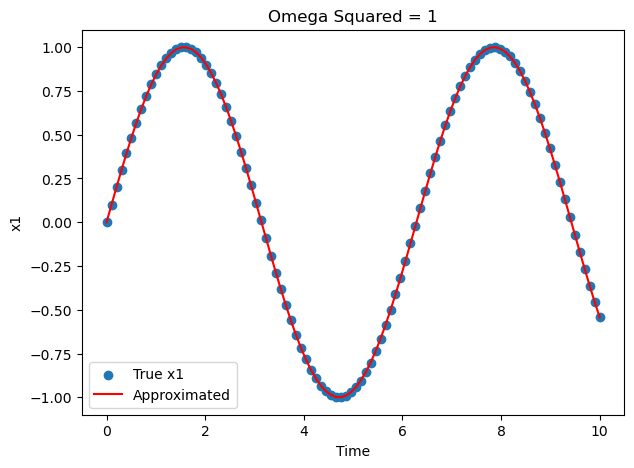

In [299]:
plt.figure(figsize=(7, 5))
plt.scatter(t, y_noisy[:, 0], label='True x1')
plt.plot(t, collocation_data[:, 0], label="Approximated", color ="red")
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


In [300]:
params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_collocation = train_nn_collocation(params_collocation, collocation_t, collocation_data, collocation_derivative, lr = 0.001, num_epochs= 1000)

Epoch 0, Loss: 0.821334958076477
Epoch 100, Loss: 3.919097071047872e-05
Epoch 200, Loss: 1.5620140402461402e-05
Epoch 300, Loss: 8.48399031383451e-06
Epoch 400, Loss: 4.977624485036358e-06
Epoch 500, Loss: 3.2029024623625446e-06
Epoch 600, Loss: 2.3169370706455084e-06
Epoch 700, Loss: 1.8453462189427228e-06
Epoch 800, Loss: 1.5487220252907719e-06
Epoch 900, Loss: 1.325679136243707e-06


In [301]:
# solve the ODE using the neural network
def neural_ode(params, y0, t):
    def func(y, t):
        return nn_forward(params, y)
    return odeint(func, y0, t)

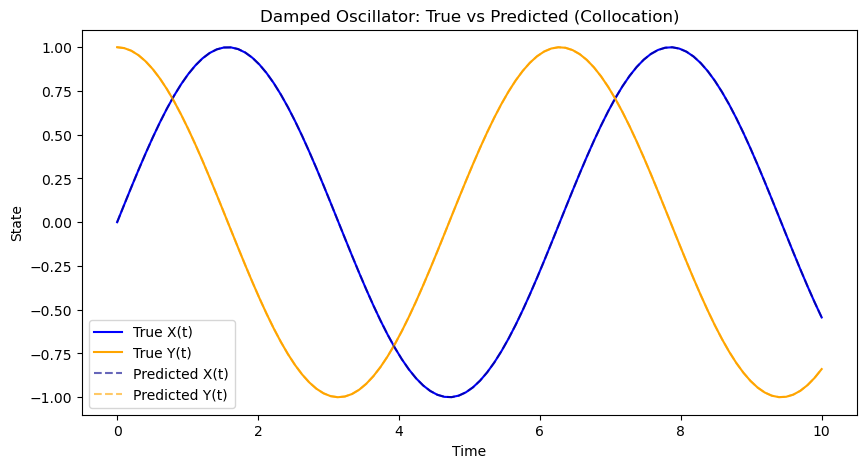

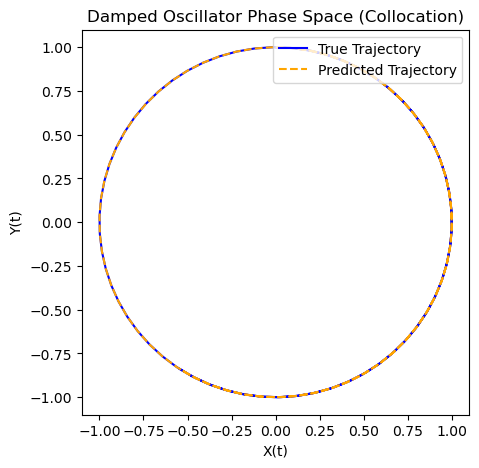

In [302]:
y0 = initial_state

# Generate predicted solution for Damped Oscillator using both methods
pred_solution_damped_collocation = neural_ode(trained_params_collocation, y0, t)

# Plot the results for Damped Oscillator
plot_trajectory(t, y, pred_solution_damped_collocation, 'Damped Oscillator: True vs Predicted (Collocation)')
plot_phase_space(y, pred_solution_damped_collocation, 'Damped Oscillator Phase Space (Collocation)')

In [312]:
t2 = jnp.array([t, t]).T
t2[0:10]

def predict_gradients(t, params):
    pred_derivative = []
    for data_point in t:
        # print(data_point.reshape(1, -1))
        derivative = nn_forward(params, data_point.reshape(1, -1))
        pred_derivative.append(derivative)
        # print(derivative.shape)
    return jnp.concatenate(pred_derivative, axis=0)

# Compute the predicted gradients
predicted_gradients = predict_gradients(t, trained_params_collocation)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (2,).

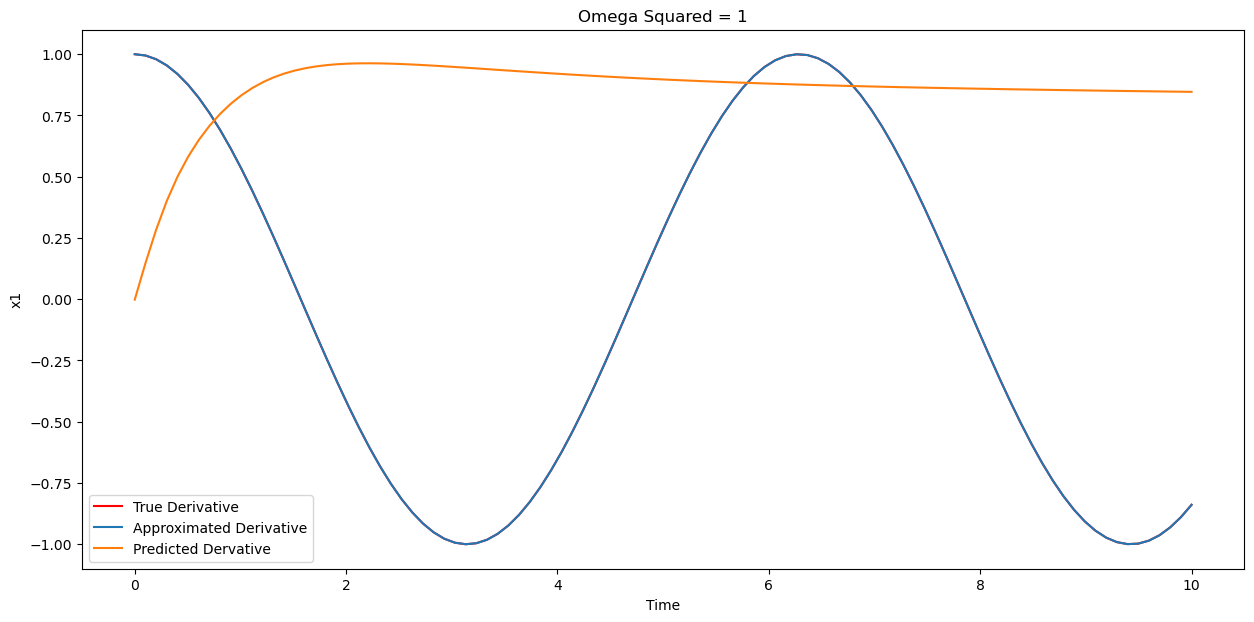

In [311]:
plt.figure(figsize=(15, 7))
# plt.scatter(t, y_noisy[:, 0], label='True x1')
plt.plot(t, true_derivatives.T[0], label="True Derivative", color ="red")
plt.plot(t, collocation_derivative.T[0], label="Approximated Derivative")
plt.plot(t, predicted_gradients.T[0], label="Predicted Dervative")
# plt.plot(t, dydx, label="Approximated Direvative", color ="r")
# plt.plot(t, true_derivatives.T[0], label="True Derivative", color ="b")
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


In [219]:
t = np.array(t)
estimated_solution = np.array(estimated_solution)
estimated_derivative = np.array(estimated_derivative)

In [220]:
def interpolate(x, y, x_new):
    """
    Interpolate a function through the points (x, y) and evaluate it at x_new.
    """
    return jnp.interp(x_new, x, y)

# Define a wrapper function to compute the interpolated values
def interpolated_function(x_new, x, y):
    return interpolate(x, y, x_new)

# Define a function to compute the derivatives at the points x
def compute_derivative(x, y):
    """
    Compute the derivative of y with respect to x using interpolation and JAX's automatic differentiation.
    """
    # Vectorize the gradient function
    grad_interpolated_function = jax.vmap(grad(lambda x_new: interpolated_function(x_new, x, y)))
    
    # Compute the gradient at each point in x
    dydx = grad_interpolated_function(x)
    
    return dydx

# Compute the derivative
dydx = compute_derivative(t, estimated_solution[0])

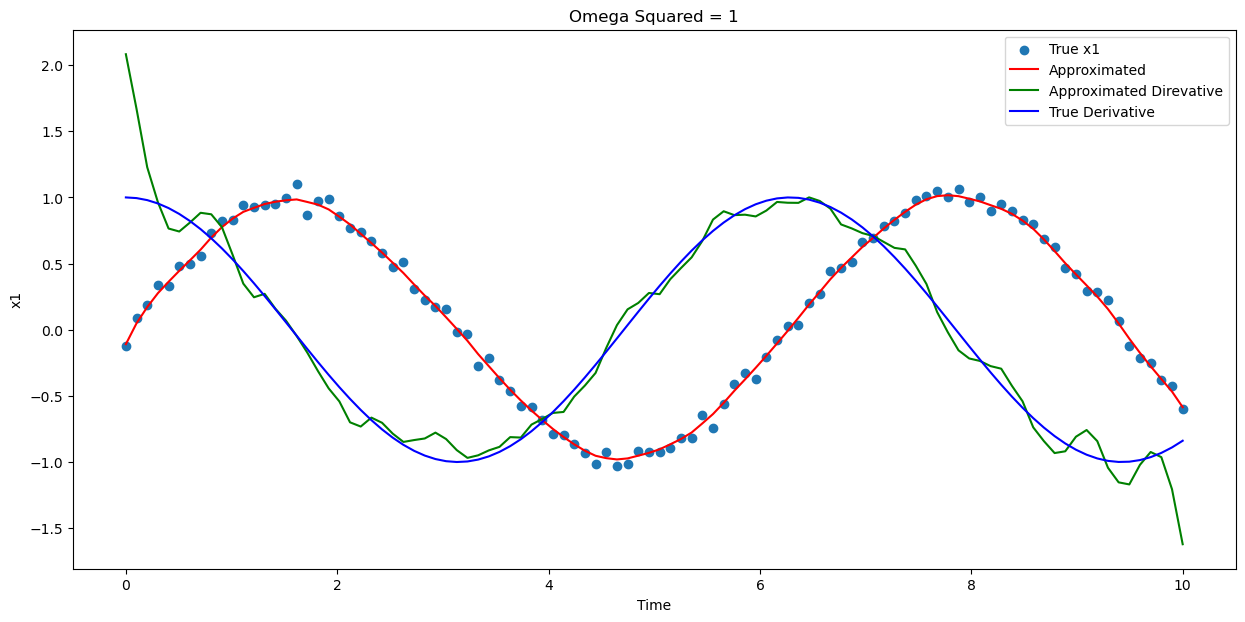

In [221]:
plt.figure(figsize=(15, 7))
plt.scatter(t, y_noisy[:, 0], label='True x1')
plt.plot(t, estimated_solution[0], label="Approximated", color ="red")

plt.plot(t, estimated_derivative[0], label="Approximated Direvative", color ="g")
# plt.plot(t, dydx, label="Approximated Direvative", color ="r")
plt.plot(t, true_derivatives.T[0], label="True Derivative", color ="b")
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


In [274]:
%%time

params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_collocation = train_nn_collocation(params_collocation, t2, estimated_solution.T, estimated_derivative.T,  lr=1e-3, num_epochs=5000)

Epoch 0, Loss: 0.8726851940155029
Epoch 100, Loss: 0.026403827592730522
Epoch 200, Loss: 0.025686604902148247
Epoch 300, Loss: 0.025192661210894585
Epoch 400, Loss: 0.024744266644120216
Epoch 500, Loss: 0.02435743249952793
Epoch 600, Loss: 0.024025602266192436
Epoch 700, Loss: 0.02371731773018837
Epoch 800, Loss: 0.02341996692121029
Epoch 900, Loss: 0.0231134295463562
Epoch 1000, Loss: 0.022737693041563034
Epoch 1100, Loss: 0.02227340079843998
Epoch 1200, Loss: 0.021810317412018776
Epoch 1300, Loss: 0.021396011114120483
Epoch 1400, Loss: 0.021012786775827408
Epoch 1500, Loss: 0.020628131926059723
Epoch 1600, Loss: 0.020221449434757233
Epoch 1700, Loss: 0.019791308790445328
Epoch 1800, Loss: 0.01934737153351307
Epoch 1900, Loss: 0.018901951611042023
Epoch 2000, Loss: 0.018469465896487236
Epoch 2100, Loss: 0.01806291751563549
Epoch 2200, Loss: 0.017675992101430893
Epoch 2300, Loss: 0.017269939184188843
Epoch 2400, Loss: 0.016850652173161507
Epoch 2500, Loss: 0.016417106613516808
Epoch 26

## Damped Oscillator

In [284]:
t2 = jnp.array([t, t]).T
t2[0:10]

def predict_gradients(t, params):
    pred_derivative = []
    for data_point in t:
        # print(data_point.reshape(1, -1))
        derivative = nn_forward(params, data_point.reshape(1, -1))
        pred_derivative.append(derivative)
        print(derivative.shape)
    return jnp.concatenate(pred_derivative, axis=0)

# Compute the predicted gradients
predicted_gradients = predict_gradients(t2, trained_params_collocation)

(1, 2)


In [286]:
predicted_gradients

Array([[-2.9386199 , -0.51981163]], dtype=float32)

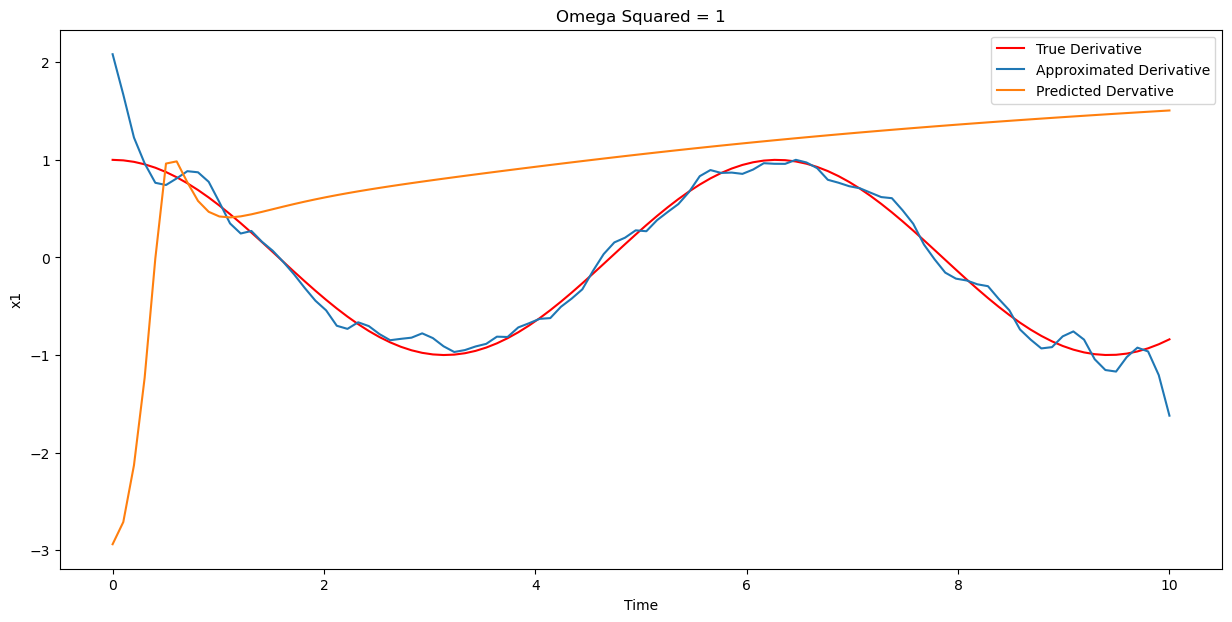

In [280]:
plt.figure(figsize=(15, 7))
# plt.scatter(t, y_noisy[:, 0], label='True x1')
plt.plot(t, true_derivatives.T[0], label="True Derivative", color ="red")
plt.plot(t, estimated_derivative[0], label="Approximated Derivative")
plt.plot(t, predicted_gradients.T[0], label="Predicted Dervative")
# plt.plot(t, dydx, label="Approximated Direvative", color ="r")
# plt.plot(t, true_derivatives.T[0], label="True Derivative", color ="b")
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


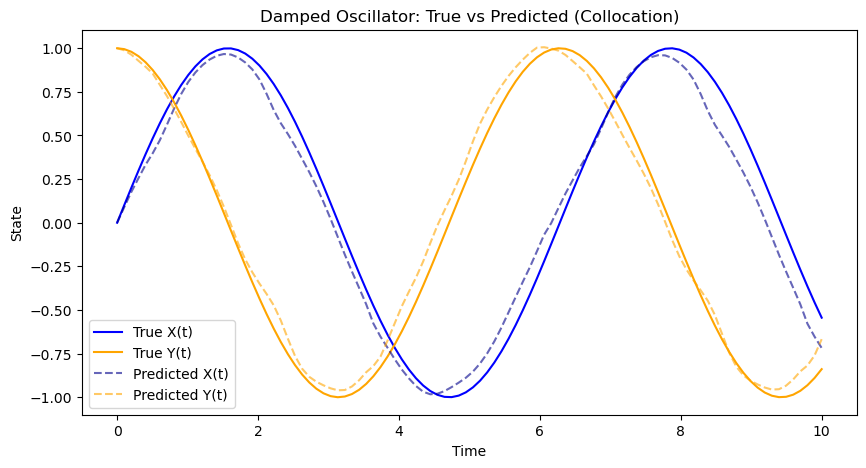

In [279]:
y0 = initial_state

# Generate predicted solution for Damped Oscillator using both methods
pred_solution_damped_collocation = neural_ode(trained_params_collocation, y0, t)

# Plot the results for Damped Oscillator
plot_trajectory(t, y, pred_solution_damped_collocation, 'Damped Oscillator: True vs Predicted (Collocation)')
# plot_phase_space(t_, pred_solution_damped_collocation, 'Damped Oscillator Phase Space (Collocation)')